In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

if 'fig' not in os.listdir():
    os.makedirs('fig')

***Example:*** We want to protect the privacy with respect to gender while processing the height of individuals. Further, for inference purposes, we may want to identify a single male in the group of individuals.

$\text{Person} -> \text{Gender} \sim \mathcal{Dir}(0.5,0.5) -> \text{Height} \sim \mathcal{N}(\mu_{gender}, \sigma_{gender})$

In [2]:
# Global parameters.

np.random.seed(42)
n = 1000

In [3]:
# Define parameters for distributions.

params = {
    'male_rate': 0.5,
    'male_mean': 178,
    'male_std': 6,
    'female_mean': 168,
    'female_std': 6
}
params['mean'] = (params['male_mean']+params['female_mean'])/2
params['std'] = ((params['male_std']**2)+(params['female_std']**2))**0.5

In [4]:
# Define distributions.

uniform = stats.uniform
normal = stats.norm

height_dist = normal(loc=params['mean'], scale=params['std'])
male_height_dist = normal(loc=params['male_mean'], scale=params['male_std'])
female_height_dist = normal(loc=params['female_mean'], scale=params['female_std'])

dist_dict = {'male':male_height_dist, 'female':female_height_dist, 'general':height_dist}

# Bayesian Inference

$$ p(\text{g}|\text{h}) = \frac{p(\text{g})\cdot p(\text{h}|\text{g})}{p(\text{h})}\text{, with g for gender and h for height.}$$

In [5]:
def gender_dist(gender, x = params['male_rate']):
    ''' Returns the distribution of males vs. females.
        Used if we want to have different examples, such as a pre-dominantely female population.
        i.e. params['male_rate'] = 0.1
    '''
    if gender == 'male':
        return x
    elif gender == 'female':
        return 1-x
    else:
        print('Error.')
        return 'Error.'

In [6]:
def gender_inference(cm):
    '''
    Compute the inference on gender given a height.
    Adversary model incorporates prior knowledge,
    i.e. an adversary may know that he is using height and looked up general population parameters.
    '''
    ll = .0
    p = {}
    for gender in ['male','female']:
        p[gender] = dist_dict[gender].pdf(cm) *gender_dist(gender)
        ll += p[gender]
    
    return (p['male']/ll, p['female']/ll)
f_gender_inference = np.vectorize(gender_inference)

f_height = lambda x: (dist_dict['male'].rvs()) if (x == 1) else dist_dict['female'].rvs()
f_height = np.vectorize(f_height)

In [7]:
# Person of 180cm.
gender_inference(180)

(0.8748396004250029, 0.12516039957499714)

An individual which we observe with `180cm`, we expect to have a 87% probability to be male.
We are comparably certain, with the default value of 50%.

In [8]:
def privatize(height, gender):
    '''
    Mean-shift the distributions towards each other such that they are overlapping.
    An adversary without prior knowledge would not be able to infer that we are 
    looking at two different distributions on the same space.
    Additionally, height observations are then naturally equally likely.
    Yet, an informed adversary will come up with the same decisions: Above 173cm expected to be male; otherwise female.
    '''
    diff = params['male_mean']-params['female_mean']
    if gender == 1:
        return height - diff*0.5
    else:
        return height + diff*0.5
f_privatize = np.vectorize(privatize)

In [9]:
gender_inference(privatize(180,1))

(0.6354235592583608, 0.3645764407416392)

Merely shifting the distribution reduces the probability of being male quiet a bit.

In [10]:
# Generate a height-sorted dataset.

uniform_samples = uniform().rvs(n)
gender = (uniform_samples > 0.5).astype(int)
obs = f_height(gender)
p_obs = f_privatize(obs, gender)

sorting_ix = obs.argsort()
gender = gender[sorting_ix]
obs = obs[sorting_ix]
p_obs = p_obs[sorting_ix]

In [11]:
# Extract probabilities to identify men in the dataset.

p_male = f_gender_inference(obs)[0]
priv_p_male = f_gender_inference(p_obs)[0]

In [12]:
def entropy_printer(p_male, priv_p_male,n):
    p_male = p_male/p_male.sum()
    priv_p_male = priv_p_male/priv_p_male.sum()
    
    optimal_entropy = - n * 1/n * np.log2(1/n)
    default_entropy = -(p_male*np.log2(p_male)).sum()
    privatized_entropy = -(priv_p_male*np.log2(priv_p_male)).sum()
    print(f'''
    Best possible entropy: {optimal_entropy:.2f}.
    Entropy of actual observations: {default_entropy:.2f}.
    Entropy after shifting distributions {privatized_entropy:.2f}.
    ''')
entropy_printer(p_male, priv_p_male, n)


    Best possible entropy: 9.97.
    Entropy of actual observations: 9.64.
    Entropy after shifting distributions 9.72.
    


# Analyze
What happened? The overall entropy increased when the distributions were shifted towards each other.

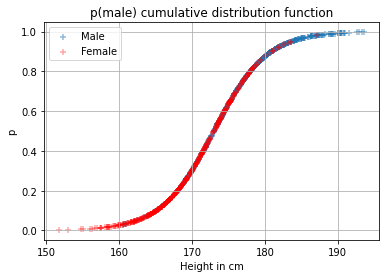

In [13]:
plt.scatter(obs[gender==1],p_male[gender==1], marker='+', alpha=0.5, label='Male');
plt.scatter(obs[gender==0],p_male[gender==0], marker='+', c='r', alpha=0.35, label='Female'); 
plt.title('p(male) cumulative distribution function')
plt.ylabel('p')
plt.xlabel('Height in cm')
plt.legend()
plt.grid()
plt.show()

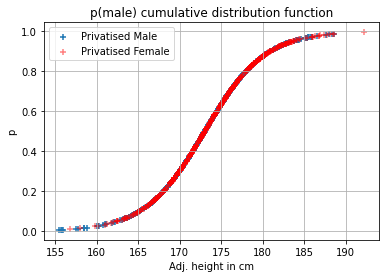

In [14]:
plt.scatter(p_obs[gender==1],priv_p_male[gender==1], marker='+', label='Privatised Male');
plt.scatter(p_obs[gender==0],priv_p_male[gender==0], marker='+', c='r', alpha=0.5, label='Privatised Female'); 
plt.title('p(male) cumulative distribution function')
plt.ylabel('p')
plt.xlabel('Adj. height in cm')
plt.legend()
plt.grid()
plt.show()

**Observations:** 

> We evaluate both gender's heights with the same function, thus lying on the same curve is not surprising. Yet, naturally, the men are on the higher end of the height observations and thus more likely to be identified as such. The split occurs at the middle of both distributions, i.e. 173cm.

> The mean shift moves both distributions upon each other as we can see in the second plot - no obvious separation of males and females can be made ex-post, i.e. an uniformed adversary would not be able to extract structure. An informed adversary would come to similar conclusions as previously - tall persons are more likely to be male.

> An informed adversary with a strong prior on the fact that the underlying distribution should be representative of the general population may even infer our privacy mechanism.

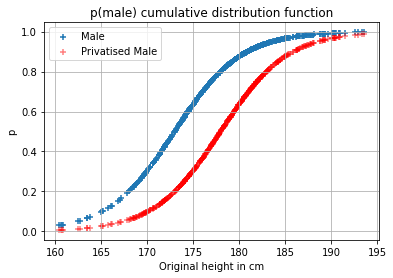

In [15]:
plt.scatter(obs[gender==1],p_male[gender==1], marker='+', label='Male');
plt.scatter(obs[gender==1],priv_p_male[gender==1], marker='+', c='r', alpha=0.5, label='Privatised Male'); 
plt.title('p(male) cumulative distribution function')
plt.ylabel('p')
plt.xlabel('Original height in cm')
plt.legend()
plt.grid()
plt.show()

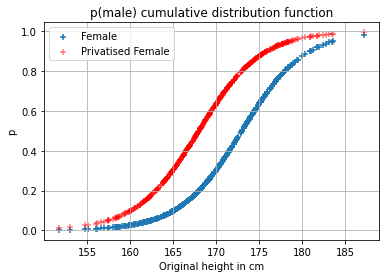

In [16]:
plt.scatter(obs[gender==0],p_male[gender==0], marker='+', label='Female');
plt.scatter(obs[gender==0],priv_p_male[gender==0], marker='+', c='r', alpha=0.5, label='Privatised Female'); 
plt.title('p(male) cumulative distribution function')
plt.ylabel('p')
plt.xlabel('Original height in cm')
plt.legend()
plt.grid()
plt.show()

**Observation:** 

> Males become less likely to be identified as such, thus more likely to be identified as females. Which is a good feature with respect to the goal of the adversary.

> The opposite holds for females, they are more likely to be identified as males. If we want to protect identification of males, this sub-group of individuals may not be relevant for our privacy evaluation.

### Height
Medium heights aka taller women and smaller men lost less, than extreme heights gained.

In [17]:
q = np.quantile(obs, [0.25,0.75])
mask = (obs < q[1]) & (obs > q[0])
print('Medium heights')
entropy_printer(p_male[mask], priv_p_male[mask], mask.sum())
print('Extreme heights')
entropy_printer(p_male[~mask], priv_p_male[~mask], (~mask).sum())

Medium heights

    Best possible entropy: 8.97.
    Entropy of actual observations: 8.87.
    Entropy after shifting distributions 8.76.
    
Extreme heights

    Best possible entropy: 8.97.
    Entropy of actual observations: 8.39.
    Entropy after shifting distributions 8.69.
    


### Gender
Men lost less entropy than women gained.

In [18]:
mask = (gender==1)

In [19]:
print('Entropies for males')
entropy_printer(p_male[mask], priv_p_male[mask], mask.sum())
print('Entropies for females')
entropy_printer(p_male[~mask], priv_p_male[~mask], (~mask).sum())

Entropies for males

    Best possible entropy: 8.96.
    Entropy of actual observations: 8.85.
    Entropy after shifting distributions 8.69.
    
Entropies for females

    Best possible entropy: 8.97.
    Entropy of actual observations: 8.49.
    Entropy after shifting distributions 8.75.
    


In [20]:
q = np.quantile(obs[gender==1], [0.15,0.85])
mask = (obs < q[1]) & (obs > q[0]) & (gender==1)  # Men w/ middle height
print('Entropies of men within p25-p75 quantile.')
entropy_printer(p_male[mask], priv_p_male[mask], mask.sum())

Entropies of men within p25-p75 quantile.

    Best possible entropy: 8.44.
    Entropy of actual observations: 8.41.
    Entropy after shifting distributions 8.32.
    


### Gender and height
Entropy is an increasing function from 0 to 37\% and decreasing afterwards.

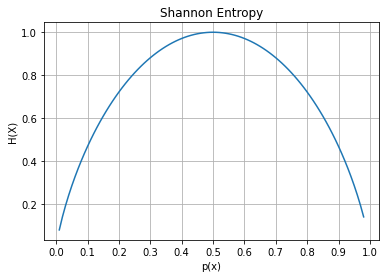

In [21]:
x = np.arange(0.01,0.99,0.01)
y = -(x*np.log2(x)+(1-x)*np.log2(1-x))
plt.title('Shannon Entropy')
plt.grid()
plt.ylabel('H(X)')
plt.xlabel('p(x)')
plt.xticks(np.arange(0,1.1,0.1))
plt.plot(x,y)

In [22]:
optimal_entropy = -np.log(1/(p_male.shape[0]))
p = (p_male/p_male.sum()); default_entropy = -p*np.log2(p)
priv_p = (priv_p_male/priv_p_male.sum()); privatized_entropy = -priv_p*np.log2(priv_p)
d_entropy = (privatized_entropy - default_entropy)

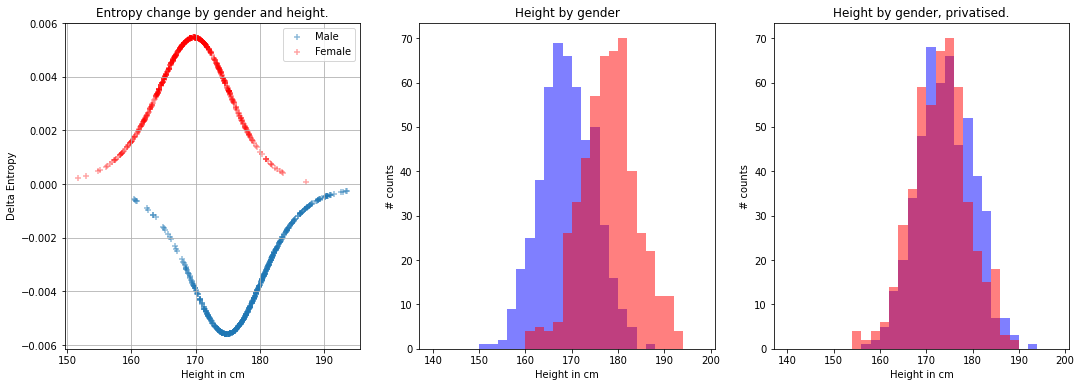

In [23]:
fig, axs = plt.subplots(1,3,figsize = (18,6))
axs[0].scatter(obs[gender==1],d_entropy[gender==1], marker='+', alpha=0.5, label='Male')
axs[0].scatter(obs[gender==0],d_entropy[gender==0], marker='+', c='r', alpha=0.35, label='Female')
axs[0].set_title('Entropy change by gender and height.')
axs[0].set_ylabel('Delta Entropy')
axs[0].set_xlabel('Height in cm')
axs[0].legend()
axs[0].grid(which='both')

bins = np.arange(140,200,2)
axs[1].hist((obs)[gender==0], color = 'b', bins = bins, alpha=0.5)
axs[1].hist((obs)[gender==1], color = 'r', bins = bins, alpha=0.5)
axs[1].set_title('Height by gender')
axs[1].set_ylabel('# counts')
axs[1].set_xlabel('Height in cm')

bins = np.arange(140,200,2)
axs[2].hist((p_obs)[gender==0], color = 'b', bins = bins, alpha=0.5)
axs[2].hist((p_obs)[gender==1], color = 'r', bins = bins, alpha=0.5)
axs[2].set_title('Height by gender, privatised.')
axs[2].set_ylabel('# counts')
axs[2].set_xlabel('Height in cm')

plt.show()

We artificially create an overlap between the two populations similar to mean-centering, such that there is no discriminatory information left to distinguish `male` from `female` in the data set. This is shown in the latter two plots - the empirical plot will never have a perfect overlap, yet both generating distributions match exactly

Informally, the adjustment of `female` observations adds more entropy than is lost by reducing the height of `male` observations. Why do we lose entropy on the male side? We moved `male` observations out of its true distribution and `females` out of it, thus naturally the males now contribute less than previously but more importantly the total contribution of `females` is larger than that of `males`. One important factor is also, that we did not adjust the adversaries evaluation distribution - he is still equipped with the original distribution and would thus assume that taller observations are more likely men, yet this is not not true for the new data set, thus the `entropy contributions` are misleading.

In [24]:
def plot_array(array,start,end):
    x = [i for i in range(start,end)]
    if array.ndim > 1:
        for i in range(0,array.ndim):
            y = array[:,i]
            plt.plot(x,y)
    else:
        y = array
        plt.plot(x,y)
    plt.yscale('log', base=2)
    plt.show()

In [25]:
def apply_measure_size(probability_array,measure,start,end):
    """
    Apply a privacy measure size wise to an array of likelihoods.
    
    param: description
    probability_array: np.array with likelihoods
    measure: function to evaluate likelihoods
    start: index to start evaluation
    end: index to end evaluation
    """
    array = np.array([])
    for i in range(start,end):
        array = np.append(array,measure(probability_array[0:i]))
    return array

In [26]:
def apply_measure_dict(probability_dict, measure):
    """
    Apply a measure to all arrays stored in a dict.
    """
    array = np.array([])
    for key in probability_dict.keys():
        array = np.append(array, measure(probability_dict[key]))
    return array

In [27]:
# Randomise variables
obs = f_height(gender)
p_obs = f_privatize(obs, gender)
p_male = f_gender_inference(obs)[0]
priv_p_male = f_gender_inference(p_obs)[0]
start = 10
end = 1000
p_male[0:10]

array([0.01990349, 0.46950566, 0.22244244, 0.02149635, 0.12962964,
       0.06645384, 0.29798087, 0.69955825, 0.01083396, 0.23197748])

In [28]:
std_array = np.concatenate([np.arange(1,30,1),np.arange(30,100,5)])
p_male_dict = {}
priv_p_male_dict = {}
for std_ in std_array:
    male_height_dist = normal(loc=params['male_mean'], scale=std_)
    #female_height_dist = normal(loc=params['female_mean'], scale=std_)
    dist_dict = {'male':male_height_dist, 'female':female_height_dist, 'general':height_dist}
    p_male_dict[std_] = f_gender_inference(obs)[0]
    priv_p_male_dict[std_] = f_gender_inference(p_obs)[0]

In [29]:
male_height_dist = normal(loc=params['male_mean'], scale=params['male_std'])
female_height_dist = normal(loc=params['female_mean'], scale=params['female_std'])
dist_dict = {'male':male_height_dist, 'female':female_height_dist, 'general':height_dist}

p_male = f_gender_inference(obs)[0]
p_male[0:10]

array([0.01990349, 0.46950566, 0.22244244, 0.02149635, 0.12962964,
       0.06645384, 0.29798087, 0.69955825, 0.01083396, 0.23197748])

#### Entropy 
$$H(X) = - \sum_{x} p(x)log_{2} p(x)$$

In [30]:
def entropy(probability_array):
    probability_array = probability_array/probability_array.sum()
    entropy = -(probability_array*np.log2(probability_array)).sum()
    return np.round(entropy,2)

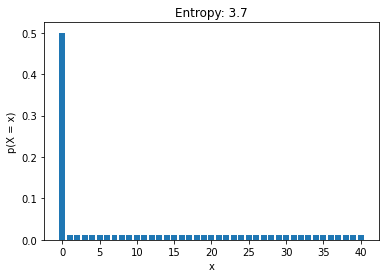

In [31]:
p = np.array([0.5]+[1/80 for i in range(40)])
entropy(p)
plt.bar(x=[i for i in range(len(p))],height=p)
plt.title(f'Entropy: {entropy(p):.1f}')
plt.ylabel(f'p(X = x)')
plt.xlabel(f'x')
plt.savefig(f'./fig/skewed-entropy.png')

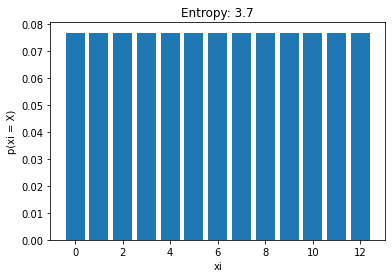

In [32]:
n = 13; 
p = np.array([1/n for i in range(n)])
entropy(p)
plt.bar(x=[i for i in range(len(p))],height=p)
plt.title(f'Entropy: {entropy(p)}')
plt.ylabel(f'p(xi = X)')
plt.xlabel(f'xi')
plt.savefig(f'./fig/uniform-entropy.png')

In [33]:
entropies = apply_measure_size(p_male,entropy,start,end)
priv_entropies = apply_measure_size(priv_p_male,entropy,start,end)

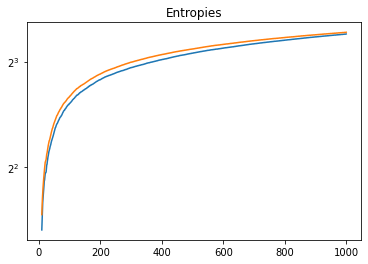

In [34]:
plt.title('Entropies')
plot_array(np.vstack([entropies,priv_entropies]).T,start,end)

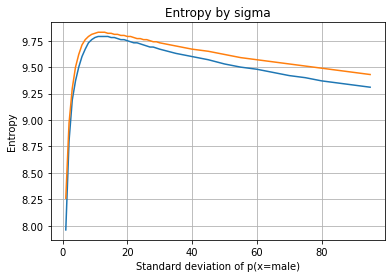

In [35]:
entropies_std = apply_measure_dict(p_male_dict,entropy)
priv_entropies_std = apply_measure_dict(priv_p_male_dict,entropy)
_std = [i for i in p_male_dict.keys()]
plt.plot(_std, entropies_std)
plt.plot(_std, priv_entropies_std)
plt.title('Entropy by sigma')
plt.xlabel('Standard deviation of p(x=male)')
plt.ylabel('Entropy')
plt.grid()
plt.show()

#### Hartley Entropy
is purely set size based and accounts for the fact that a larger population size leads to more privacy generally.
$$H_{0}(X) = -\log_{2} |X|$$

In [36]:
def hartley_entropy(probability_array):
    probability_array = probability_array/probability_array.sum()
    return np.round(np.log2(probability_array.shape[0]),2)

In [37]:
hartley_entropies = apply_measure_size(p_male,hartley_entropy,start,end)
priv_hartley_entropies = apply_measure_size(priv_p_male,hartley_entropy,start,end)

#[]
#for i in range(start,end):
#    input_array = p_male.copy()
#    hartley_entropies.append(hartley_entropy(input_array[0:i]))

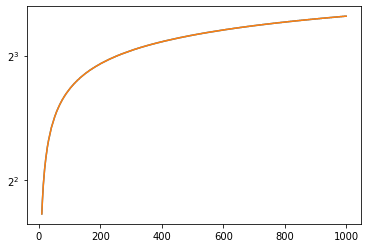

In [38]:
plot_array(np.vstack([hartley_entropies,priv_hartley_entropies]).T,start,end)

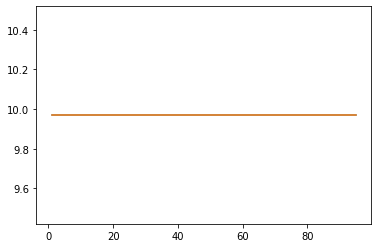

In [39]:
hartley_entropies_std = apply_measure_dict(p_male_dict,hartley_entropy)
priv_hartley_entropies_std = apply_measure_dict(priv_p_male_dict,hartley_entropy)
_std = [i for i in p_male_dict.keys()]
plt.plot(_std, hartley_entropies_std)
plt.plot(_std, priv_hartley_entropies_std)

#### Min-Entropy
measures the Entropy of the `worst off` individual.
$$H_{\infty}(X) = - log_{2}  \max_{p} p(x)$$

In [40]:
def min_entropy(probability_array):
    probability_array = probability_array/probability_array.sum()
    return np.round(-np.log2(np.max(probability_array)),3)

In [41]:
min_entropies = apply_measure_size(p_male,min_entropy,start,end)#
priv_min_entropies = apply_measure_size(priv_p_male,min_entropy,start,end)#

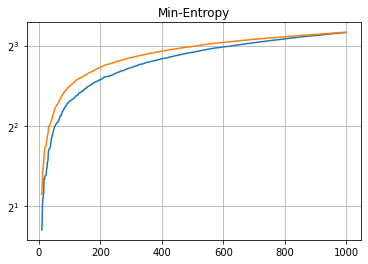

In [42]:
plt.title('Min-Entropy')
plt.grid()
plot_array(np.vstack([min_entropies,priv_min_entropies]).T,start,end)

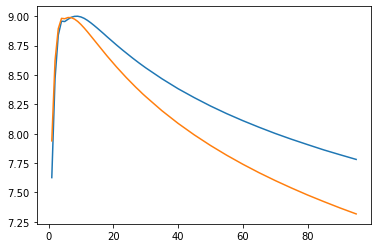

In [43]:
min_entropies_std = apply_measure_dict(p_male_dict,min_entropy)
priv_min_entropies_std = apply_measure_dict(priv_p_male_dict,min_entropy)
_std = [i for i in p_male_dict.keys()]
plt.plot(_std, min_entropies_std)
plt.plot(_std, priv_min_entropies_std)

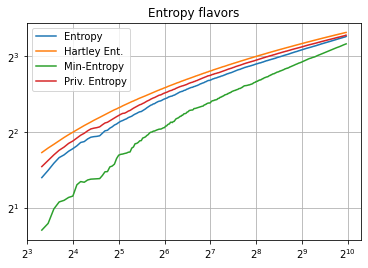

In [44]:
x = [i for i in range(start,end)]
plt.plot(x,entropies,label='Entropy')
plt.plot(x,hartley_entropies, label='Hartley Ent.')
plt.plot(x,min_entropies, label='Min-Entropy')
plt.plot(x,priv_entropies,label='Priv. Entropy')
plt.yscale('log', base=2)
plt.xscale('log', base=2)
plt.title('Entropy flavors')
plt.grid()
plt.legend()
plt.show()

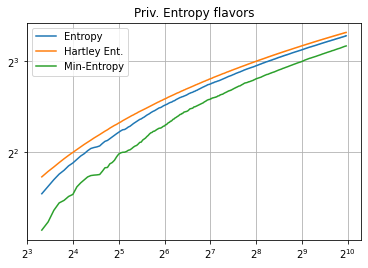

In [45]:
x = [i for i in range(start,end)]
plt.plot(x,priv_entropies,label='Entropy')
plt.plot(x,priv_hartley_entropies, label='Hartley Ent.')
plt.plot(x,priv_min_entropies, label='Min-Entropy')
plt.yscale('log', base=2)
plt.xscale('log', base=2)
plt.title('Priv. Entropy flavors')
plt.grid()
plt.legend()
plt.show()

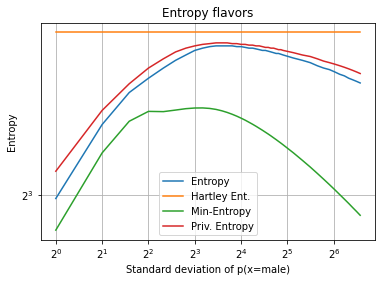

In [46]:
x = std_array
plt.plot(x,entropies_std,label='Entropy')
plt.plot(x,hartley_entropies_std, label='Hartley Ent.')
plt.plot(x,min_entropies_std, label='Min-Entropy')
plt.plot(x,priv_entropies_std,label='Priv. Entropy')
plt.yscale('log', base=2)
plt.xscale('log', base=2)
plt.title('Entropy flavors')
plt.grid()
plt.xlabel('Standard deviation of p(x=male)')
plt.ylabel('Entropy')
plt.legend()
plt.show()

#### Normalized Entropy 
accounts for the fact that Entropy is increasing in set size; i.e. higher `privacy` would be achieved purely by incorporating more data.
$$\frac{H(X)}{H_{0}(X)}$$

In [47]:
def normalized_entropy(probability_array):
    normalized_entropy = entropy(probability_array)/hartley_entropy(probability_array)
    return np.round(normalized_entropy,2)

In [48]:
norm_entropies = np.array([i/j for i,j in zip(entropies,hartley_entropies)])
priv_norm_entropies = np.array([i/j for i,j in zip(priv_entropies,priv_hartley_entropies)])

In [49]:
norm_entropies_std = np.array([i/j for i,j in zip(entropies_std,hartley_entropies_std)])
priv_norm_entropies_std = np.array([i/j for i,j in zip(priv_entropies_std,priv_hartley_entropies_std)])
_std = [i for i in p_male_dict.keys()]

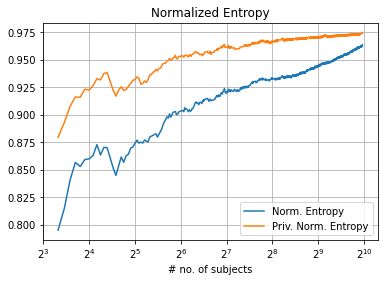

In [50]:
x = [i for i in range(start,end)]
plt.plot(x,norm_entropies,label='Norm. Entropy')
plt.plot(x,priv_norm_entropies,label='Priv. Norm. Entropy')
#plt.yscale('log', base=2)
plt.xscale('log', base=2)
plt.title('Normalized Entropy')
plt.xlabel('# no. of subjects')

plt.grid()
plt.legend()
plt.show()

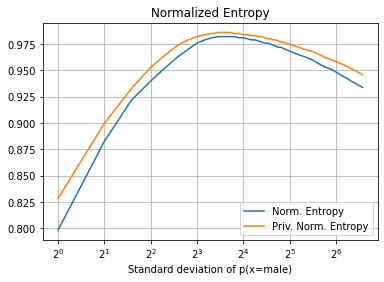

In [51]:
x = _std
plt.plot(x,norm_entropies_std,label='Norm. Entropy')
plt.plot(x,priv_norm_entropies_std,label='Priv. Norm. Entropy')
#plt.yscale('log', base=2)
plt.xscale('log', base=2)
plt.title('Normalized Entropy')
plt.xlabel('Standard deviation of p(x=male)')

plt.grid()
plt.legend()
plt.show()

#### Anonymity Set Size

similar to *Hartley Entropy*; fundamental measure for privacy.

$\text{Size}_{AS} = |AS_{I}|$

In [52]:
p_male.shape[0]
priv_p_male.shape[0]

1000

#### Amount of Leakaed Information

similar to Anonymity Set Size; i.e. number of individuals exceeding some identification threshold. Applied mostly in specific domains such as Genomics.

$$|S| \text{ such that } \forall s_{i} \in U: p(s_{i} = u_{i}) > \alpha,$$
where $S$ is the set of disclosed individuals out of the "universe" or total set $U$.

In [53]:
alpha = 0.0018
((priv_p_male/priv_p_male.sum()) > alpha).sum()

80

#### Mutual Information

it quantifies the "amount of information" obtained about one random variable through observing the other random variable. The concept of mutual information is intimately linked to that of entropy of a random variable, a fundamental notion in information theory that quantifies the expected "amount of information" held in a random variable.

$I(X;Y) = H(X) - H(X|Y)$

In [54]:
n = p_male.shape[0]
mi = -n*((1/n)*np.log2(1/n)) - entropy(p_male)
print(f'{mi:.2f}')

0.37


In [55]:
n = priv_p_male.shape[0]
mi = -n*((1/n)*np.log2(1/n)) - entropy(priv_p_male)
print(f'{mi:.2f}')

0.26


**Observation:**
> The Mutual Information is lower for the privatized random variable, so the added information of observing it is smaller compared to the original height variable.

#### Information Surprisal

Information Surprisal (IS) was introduced for the purpose
of studying the uniqueness of demographics and thus the propensity to reidentify
a person in third party data sets. IS measures information of a
specific outcome of a random variable. 
For example, observing an individual larger than 190cm yields more information after decreasing each male's height.

In [56]:
np.round(-np.log2((obs>190).sum()/n),2)

6.64

In [57]:
np.round(-np.log2((p_obs>190).sum()/n),2)

7.97

### Data Similarity

#### k-Anonymity
Specific identifiers such as the name of
an individual are removed. Quasi-identifiers $q$ (such as height in our example) remain and are required to
be indistuinguishable among $k$ data entries given their equivalence class $E$.

$$k=max(|E_{i}|) \forall i$$

In [58]:
def k_anonymity(obs):
    return np.unique(obs, return_counts=True)[1].min()
print(f'k = {k_anonymity(obs)}')

k = 1


In [59]:
bins=np.arange(obs.min(),obs.max(),3)
p_obs = np.digitize(obs,bins)
print(f'k = {k_anonymity(p_obs)}')

k = 2


In [60]:
bins=np.arange(obs.min(),obs.max(),10)
p_obs = np.digitize(obs,bins)
print(f'k = {k_anonymity(p_obs)}')

k = 13


In [61]:
bins=np.arange(obs.min(),obs.max(),25)
p_obs = np.digitize(obs,bins)
print(f'k = {k_anonymity(p_obs)}')

k = 409


Data Similarity does not care about inference but the individual. Trivially, when I force at least 20 entries to be the same for each combination, then an adversary cannot recover the individual. Yet, data similarity does not break inference and thus does not necessarily establish legal requirements of the policy maker. If the regulator requires not to process sex as it is not required for the task, for example when deciding on the relative proportions to produce of garment sizes.

We can account for gender when assigning bins, similar to sizes of XS, S, M, L, XL.

In [62]:
size_dict = {
    0:'XS',
    1:'S',
    2:'M',
    3:'L',
    4:'XL'   
}

In [63]:
q = [0.20,.4,.6,.8]
bins=np.quantile(obs,q)
p_obs = np.digitize(obs,bins)
print('Proportion of males in bins.')
print(f'First bin: {gender[obs<bins[1]].mean()*100:.2f}%')
print(f'Last bin: {gender[obs>bins[-2]].mean()*100:.2f}%')
print(f'k = {k_anonymity(np.vectorize(size_dict.get)(p_obs))}')

Proportion of males in bins.
First bin: 12.50%
Last bin: 87.00%
k = 200


In [64]:
m_bins=np.quantile(obs[gender==1],q)
f_bins=np.quantile(obs[gender==0],q)
m_p_obs= np.digitize(obs[gender==1],m_bins)
f_p_obs= np.digitize(obs[gender==0],f_bins)
p_obs = np.concatenate([f_p_obs,m_p_obs])

In [65]:
p_obs.sort()
print('Proportion of males in bins.')
print(f'First bin: {((m_p_obs==0).astype(int).sum()/(p_obs==0).sum())*100:.2f}%')
print(f'Last bin: {((m_p_obs==4).astype(int).sum()/(p_obs==4).sum())*100:.2f}%')
print(f'k = {k_anonymity(np.vectorize(size_dict.get)(p_obs))}')

Proportion of males in bins.
First bin: 49.75%
Last bin: 49.75%
k = 199


In [66]:
def get_size_counts(obs):
    size, count = np.unique(np.vectorize(size_dict.get)(p_obs),return_counts=True)
    return size, count

size, count = get_size_counts(p_obs)
for s,c in zip(size,count):
    print(f'{s}: {c}')

L: 199
M: 200
S: 199
XL: 201
XS: 201


The approach reveals further aspects which have to be taken into account. We rely on empirical quantiles in this example, therefore we need sufficient data to build these quantiles and require that the underlying distribution is stable and unbiased. All three of these aspects have considerable repercussions in real data applications.

`Sufficient data` is a problem in itself. How do we come up with non-private data to privatise data? We may be able to buy or source such data, thus representing an additional, economic effort for the data processor. This may be less costly for general demographic data such as sex-height-weight relations and costlier for specialized domains such as time-series of energy consumption. Lastly, determining the applicable size of the data is not trivial either, given the underlying distribution not known either.

Comparing the Laplace distribution with the Normal distribution, we require 50\% more data given a Laplace distributed random variable given the same quality standard of `1cm` standard deviation in the quantile estimation. These numbers are still rather well-behaved as we do not try to infer multiple, interacting factors at once (curse of dimensionality) and the distributions in itself are known.

In [67]:
height = dist_dict['general']
lq = []
np.random.seed(8008135)
for i in range(10000):
    lq.append(np.quantile(height.rvs(size=132), 0.25))
lq = np.array(lq)
print(f'Mean 25% Quantile: {lq.mean():.2f}, Stddev. of mean:{lq.std():.2f}')

Mean 25% Quantile: 167.35, Stddev. of mean:1.00


In [68]:
laplace = stats.laplace(loc=params['mean'],scale=params['std'])
lq = []
np.random.seed(8008135)
for i in range(10000):
    lq.append(np.quantile(laplace.rvs(size=216), 0.25))
lq = np.array(lq)
print(f'Mean 25% Quantile: {lq.mean():.2f}, Stddev. of mean:{lq.std():.2f}')

Mean 25% Quantile: 167.13, Stddev. of mean:1.00


`Stable distribution` is a problem for real environments, as trends and seasons change, so will the underlying distribution and our privatizing mechanism has to account for that. If a female group becomes more sizing aware and reluctant to buy XL but rather L, then the distributions within both bins will change and subsequently information may be leaking during that period. A `biased distribution` can have the same effect, given there is merely a mean shift due to instability.

In [69]:
m_p_obs= np.digitize(dist_dict['male'].rvs(1000),m_bins)
f_p_obs= np.digitize(normal(loc=params['female_mean']-5,scale=params['female_std']).rvs(size=1000), f_bins)
p_obs = np.concatenate([f_p_obs,m_p_obs])
print(f'Smallest ppl bin: {((m_p_obs==0).sum()/(p_obs==0).sum())*100:.2f}% males')
print(f'Tallest ppl bin: {((m_p_obs==4).sum()/(p_obs==4).sum())*100:.2f}% males')

Smallest ppl bin: 30.40% males
Tallest ppl bin: 75.49% males


A privacy engineer can then decide on methods to control for these effects.
With a model-based approach, the estimated quantiles will be less sensitive to single observations as an adequate distribution is assumed. The distribution can be selected through Bayesian Model Comparision. Domain-specific requirements can be established.

Data-driven methods will require a pre-cautious approach, as the risk is towards unintended leakage. This will come with additional costs to the data collection, as data quality has to artifically lowered.

#### t-Closeness

In [70]:
bins=np.arange(obs.min(),obs.max(),15)
p_obs = np.digitize(obs,bins)

def d(S,S_E):
    '''Wasserstein Distance'''
    return stats.wasserstein_distance(S,S_E)

def t_closeness(S,S_E,t):
    return d(S,S_E)<t

for Bin in np.unique(p_obs):
    S = obs
    S_E = obs[p_obs == Bin]
    print(f'Bin: {Bin}, t_closeness erfuellt: {t_closeness(S,S_E,5)}.')

Bin: 1, t_closeness erfuellt: False.
Bin: 2, t_closeness erfuellt: True.
Bin: 3, t_closeness erfuellt: False.
Bin: 4, t_closeness erfuellt: False.


### Indistinguishability

#### Semantic Security

Player A chooses the data to be
fed into the privacy protocol of player B. Player B returns two outcomes to
player A, who has to select one based on an estimation. If player A cannot
distinguish the outputs with a probability significantly different from 1
2 , the
protocol is private with resepect to some time complexity or computational
ressources. Given the difference is zero, the protocol satisifies unconditional
privacy.

In [71]:
def trivial_privacy_mechanism(obs):
    return 173
eps = 0.05
A_selection = obs
B_answer = trivial_privacy_mechanism(obs)
A_inference = f_gender_inference(B_answer)
A_inference[0] < .5+eps

True

#### Differential Privacy & Laplace Mechanism

Differential Privacy (Dwork, 2006) gives formal privacy guarantees through
adding calibrated noise to the results of a database query. Database queries
should yield the same answer, whether or not an individual record is contained
in the database. Formally, a query $\mathcal{S}$ to two databases with a Hamming
distance $\equiv$ 1 can differ at most $exp(\epsilon)$ given some noise function $\mathcal{F}$:

$$\forall S \subseteq	 Range(\mathcal{F}): p(\mathcal{F}(D_{x}\in S)) \leq exp(\epsilon) \cdot p(\mathcal{F}(D_{y} \in S))$$

The guarantee is derived as follows:

$${\displaystyle {\begin{aligned}{\frac {\mathrm {Pr} ({\mathcal {M}}_{\mathrm {Lap} }(x,f,\epsilon )=z)}{\mathrm {Pr} ({\mathcal {M}}_{\mathrm {Lap} }(y,f,\epsilon )=z)}}&={\frac {\mathrm {Pr} (f(x)+\mathrm {Lap} (0,{\frac {\Delta f}{\epsilon }})=z)}{\mathrm {Pr} (f(y)+\mathrm {Lap} (0,{\frac {\Delta f}{\epsilon }})=z)}}\\&={\frac {\mathrm {Pr} (\mathrm {Lap} (0,{\frac {\Delta f}{\epsilon }})=z-f(x))}{\mathrm {Pr} (\mathrm {Lap} (0,{\frac {\Delta f}{\epsilon }})=z-f(y))}}\\&={\frac {{\frac {1}{2b}}\exp \left(-{\frac {|z-f(x)|}{b}}\right)}{{\frac {1}{2b}}\exp \left(-{\frac {|z-f(y)|}{b}}\right)}}\\&=\exp \left({\frac {|z-f(y)|-|z-f(x)|}{b}}\right)\\&\leq \exp \left({\frac {|f(y)-f(x)|}{b}}\right)\\&\leq \exp \left({\frac {\Delta f}{b}}\right)=\exp(\epsilon ).\end{aligned}}} 
$$

In [72]:
np.random.seed(1)
F = np.mean # Query
F(obs)
eps = 1
sensitivity = (obs.max()-obs.min())
noise = stats.laplace.rvs(0,sensitivity/eps,size=n)
p_obs = obs + noise

In [73]:
print(f'New mean: {F(p_obs):.2f}, old mean: {F(obs):.2f}.')

New mean: 171.98, old mean: 173.06.


In [74]:
# Double check on binning and k-anonymity.

In [75]:
m_p_obs= np.digitize(p_obs[gender==1],m_bins)
f_p_obs= np.digitize(p_obs[gender==0],f_bins)
p_obs = np.concatenate([f_p_obs,m_p_obs])

In [76]:
print('Proportion of males in bins.')
print(f'First bin: {((m_p_obs==0).astype(int).sum()/(p_obs==0).sum())*100:.2f}%')
print(f'Last bin: {((m_p_obs==4).astype(int).sum()/(p_obs==4).sum())*100:.2f}%')
print(f'k = {k_anonymity((p_obs))}')

Proportion of males in bins.
First bin: 53.11%
Last bin: 46.67%
k = 30


In [77]:
bins, counts = np.unique(p_obs, return_counts=True)
for b, c in zip(bins, counts):
    print(f'Bin {b}: {c} obs, {((m_p_obs==b).astype(int).sum()/(p_obs==b).sum())*100:.2f}% males')

Bin 0: 450 obs, 53.11% males
Bin 1: 35 obs, 42.86% males
Bin 2: 35 obs, 51.43% males
Bin 3: 30 obs, 50.00% males
Bin 4: 450 obs, 46.67% males


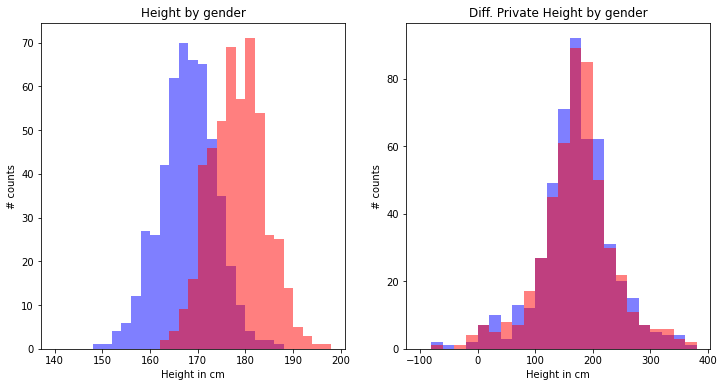

In [78]:
# Plot original distribution. 
fig, axs = plt.subplots(1,2,figsize = (12,6))

bins = np.arange(140,200,2)
axs[0].hist((obs)[gender==0], color = 'b', bins = bins, alpha=0.5)
axs[0].hist((obs)[gender==1], color = 'r', bins = bins, alpha=0.5)
axs[0].set_title('Height by gender')
axs[0].set_ylabel('# counts')
axs[0].set_xlabel('Height in cm')

bins = np.arange(-100,400,20)
axs[1].hist((obs+noise)[gender==0], color = 'b', bins = bins, alpha=0.5)
axs[1].hist((obs+noise)[gender==1], color = 'r', bins = bins, alpha=0.5)
axs[1].set_title('Diff. Private Height by gender')
axs[1].set_ylabel('# counts')
axs[1].set_xlabel('Height in cm')

plt.savefig(f'./fig/dp-height-gender.png')
plt.show()

The feature `height` is now protected. General queries can still be answered, such as quantiles or average height of a specific sex, yet since the individual `height` record is sufficiently noisy to prohibit inference regarding its true value, then the `gender` is protected as well.

We could also protect `gender` directly. Depending on the task, this would enable us to have a more informative channel rather than a differentially private height. Working directly on gender puts special requirements on the data pipeline as well as the prediction process.

#### Success rates

In [79]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    obs.reshape(-1,1), gender, test_size=0.33, random_state=42)
model = lr(penalty='none')
model.fit(X=X_train,y=y_train)
p = model.predict_proba(X_test.reshape(-1, 1))

In [81]:
(np.where(y_test==1,p[:,1], p[:,0])>0.5).sum()
print(f'Correctly identified individuals: {(np.where(y_test==1,p[:,1], p[:,0])>=0.5).sum()} ')
#print(f'Correctly identified individuals: {(np.where(y_test==1,p[:,1], p[:,0])).sum()} ')

Correctly identified individuals: 271 


In [82]:
eps = 1
sensitivity = (obs.max()-obs.min())
noise = stats.laplace.rvs(0,sensitivity/eps,size=n)

X_train, X_test, y_train, y_test = train_test_split(
    (obs+noise).reshape(-1, 1), gender, test_size=0.33, random_state=42)
model = lr(penalty='none')
model.fit(X=X_train,y=y_train)
p = model.predict_proba(X_test.reshape(-1, 1))

In [83]:
(np.where(y_test==1,p[:,1], p[:,0])>0.5).sum()
#print(f'Correctly identified individuals: {(np.where(y_test==1,p[:,1], p[:,0])>=0.5).sum()} ')
print(f'Correctly identified individuals: {(np.where(y_test==1,p[:,1], p[:,0])).sum():.2f} ')

Correctly identified individuals: 167.80 


In [84]:
def perc_by_eps(eps):
    sensitivity = (obs.max()-obs.min())
    noise = stats.laplace.rvs(0,sensitivity/eps,size=n,random_state=2)

    X_train, X_test, y_train, y_test = train_test_split(
        (obs+noise).reshape(-1, 1), gender, test_size=0.33, random_state=2)
    model = lr(penalty='l2')
    model.fit(X=X_train,y=y_train)
    p = model.predict_proba(X_test.reshape(-1, 1))
    return (np.where(y_test==1,p[:,1], p[:,0])>0.5).sum()/p.shape[0]
x = np.exp(np.arange(-4,6,0.25))
y = np.array([perc_by_eps(i) for i in x])

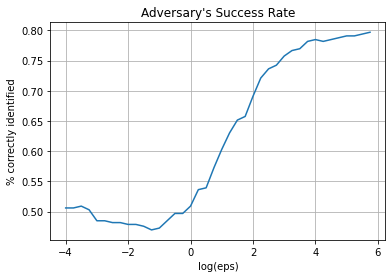

In [85]:
plt.plot(np.log(x),y)
plt.title('Adversary\'s Success Rate')
plt.ylabel('% correctly identified')
plt.xlabel('log(eps)')
plt.grid()
plt.show()

#### Mean-shift privacy

In [86]:
p_obs = f_privatize(obs, gender)
X_train, X_test, y_train, y_test = train_test_split(
    p_obs.reshape(-1,1), gender, test_size=0.33, random_state=1)
model = lr(penalty='none')
model.fit(X=X_train,y=y_train)
p = model.predict_proba(X_test.reshape(-1, 1))
(np.where(y_test==1,p[:,1], p[:,0])>0.5).sum()
print(f'Correctly identified individuals: {(np.where(y_test==1,p[:,1], p[:,0])>=0.5).sum()/y_test.size * 100:.1f}%.')
print(f'There remains no information from height to infer gender.')

Correctly identified individuals: 50.3%.
There remains no information from height to infer gender.


#### Confidence Interval Width

$$|x_{1} - x_{2}|, \text{ given } p(x_{1} < x < x_{2}) < \tau$$

In [87]:
import statsmodels.api as sm

# Calibrate noise.
eps = 1
sensitivity = (obs.max()-obs.min())
noise = stats.laplace.rvs(0,sensitivity/eps,size=n,random_state=2)

Optimization terminated successfully.
         Current function value: 0.402981
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  900
Model:                          Logit   Df Residuals:                      898
Method:                           MLE   Df Model:                            1
Date:                Thu, 29 Oct 2020   Pseudo R-squ.:                  0.4185
Time:                        16:33:55   Log-Likelihood:                -362.68
converged:                       True   LL-Null:                       -623.69
Covariance Type:            nonrobust   LLR p-value:                1.543e-115
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -54.3864      3.560    -15.278      0.000     -61.363     -47.409
x1             0.3142      0.

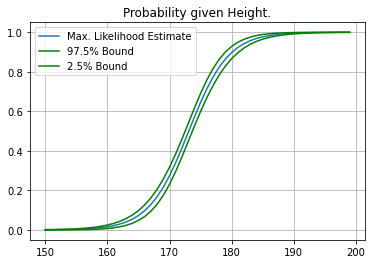

95% CI Width for 190cm person: 0.70%


In [88]:
def plot_and_print_logit(obs,person_size):
    # Create discriminating model: Frequentist logistic regression.
    X_train, X_test, y_train, y_test = train_test_split(
            (obs).reshape(-1, 1), gender, test_size=0.1, random_state=2)
    X_test = sm.add_constant(X_test)
    X_train = sm.add_constant(X_train)
    est = sm.Logit(y_train, X_train)
    est = est.fit()
    
    np.random.seed(1)

    # Calculate predictive probabilitites.
    X = np.arange(150,200)
    X = sm.add_constant(X)
    proba = est.predict(X)

    # Calculate confidence intervalls assuming Gaussian noise. [Plain vanilla LR]
    cov = est.cov_params()
    gradient = (proba * (1 - proba) * X.T).T # matrix of gradients for each observation
    std_errors = np.array([np.sqrt(np.dot(np.dot(g, cov), g)) for g in gradient])
    c = 1.96 # Gaussian 2.5%/97.5% quantile multiplier
    upper = np.maximum(0, np.minimum(1, proba + std_errors * c))
    lower = np.maximum(0, np.minimum(1, proba - std_errors * c))

    print(est.summary())

    plt.plot(X[:,1], proba, label='Max. Likelihood Estimate')
    plt.plot(X[:,1], lower, color='g', label='97.5% Bound')
    plt.plot(X[:,1], upper, color='g', label='2.5% Bound')
    plt.title('Probability given Height.')
    plt.legend()
    plt.grid()
    plt.show()

    print(f'95% CI Width for {person_size}cm person: {((upper[X[:,1]==person_size]-lower[X[:,1]==person_size])*100)[0]:.2f}%')
    
plot_and_print_logit(obs,190)

Optimization terminated successfully.
         Current function value: 0.684041
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  900
Model:                          Logit   Df Residuals:                      898
Method:                           MLE   Df Model:                            1
Date:                Thu, 29 Oct 2020   Pseudo R-squ.:                 0.01291
Time:                        16:33:55   Log-Likelihood:                -615.64
converged:                       True   LL-Null:                       -623.69
Covariance Type:            nonrobust   LLR p-value:                 5.989e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7555      0.196     -3.861      0.000      -1.139      -0.372
x1             0.0042      0.

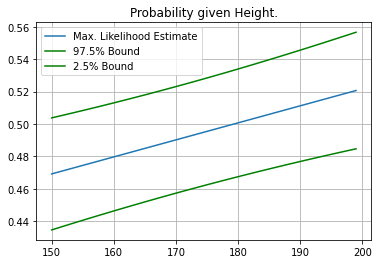

95% CI Width for 190cm person: 6.89%


In [89]:
plot_and_print_logit(obs+noise,190)

### Hardening a dataset using the Laplace Mechanism

In [90]:
import sklearn.datasets as _data
data = _data.load_diabetes(return_X_y=False)
df = pd.DataFrame(data['data'], columns=data['feature_names'])

In [91]:
# Generate entirely differentially private dataframe in one call.
np.random.seed(42)
col_sens = df.agg(['min','max']).diff().loc['max',:]
eps = 1
size = df.shape[0]
p_df = df.apply(lambda x: x+stats.laplace.rvs(0,
                                       col_sens[x.name]/eps,
                                       size=size
                                      ),
                axis=0).copy()

df.apply(lambda x: np.round(col_sens[x.name],3)*100, axis=0)

age    21.8
sex     9.5
bmi    26.1
bp     24.4
s1     28.1
s2     31.4
s3     28.3
s4     26.2
s5     26.0
s6     27.3
dtype: float64

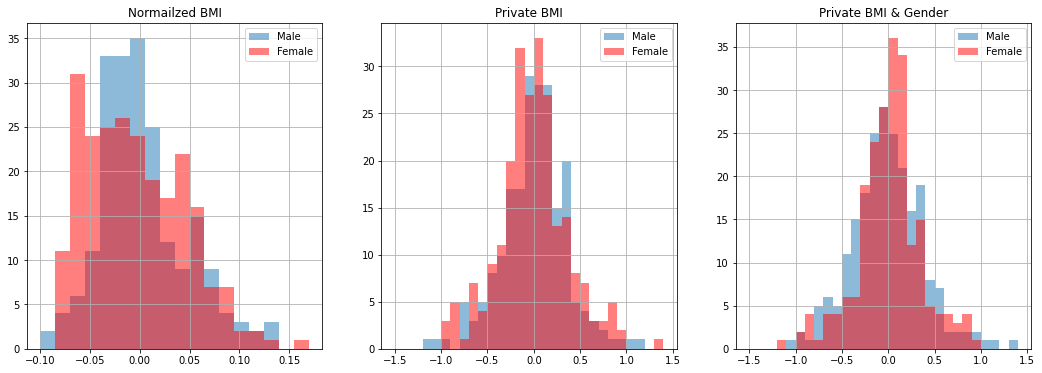

In [92]:
fig, axs = plt.subplots(1,3,figsize=(18,6))

bins = np.arange(-.1,.18,0.015)
axs[0].hist(df.loc[df['sex']>0,'bmi'].values,alpha=0.5, bins=bins,label='Male')
axs[0].hist(df.loc[df['sex']<0,'bmi'].values,color='r',alpha=0.5, bins=bins,label='Female')
axs[0].set_title('Normailzed BMI')
axs[0].grid()
axs[0].legend()

bins = np.arange(-1.5,1.5,0.1)
axs[1].hist(p_df.loc[df['sex']>0,'bmi'].values,alpha=0.5, bins=bins,label='Male')
axs[1].hist(p_df.loc[df['sex']<0,'bmi'].values,color='r',alpha=0.5, bins=bins,label='Female')
axs[1].set_title('Private BMI')
axs[1].grid()
axs[1].legend()

bins = np.arange(-1.5,1.5,0.1)
axs[2].hist(p_df.loc[p_df['sex']>0,'bmi'].values,alpha=0.5, bins=bins,label='Male')
axs[2].hist(p_df.loc[p_df['sex']<0,'bmi'].values,color='r',alpha=0.5, bins=bins,label='Female')
axs[2].set_title('Private BMI & Gender')
axs[2].grid()
axs[2].legend()

plt.show()

A quick online search confirms that women have a flatter BMI distribution compared to men - thus we can infer that the higher `sex` value represents men, without consulting the dataset documentation - the author of this notebook did not.

An individual is composed of private and non-private information and thus uniquely identifiable. Therefore, protecting private information automatically implies protecting the individual. The claim does not work vice versa. Vast information with respect to certain features can remain while establishing a satisfying level of anonymity for the individuals of the data set. `k-anonymity` provides a straight forward example with depending on the binning we establish sufficient anonymity for the unique size of an individual in the data set but a discriminator could infer the gender and the remaining data set would add value to recombination with external data sources which do not yet contain gender information, to re-identify invidiuals.

Consequently, either internal protocols have to be in-place to safeguard against re-use of the dataset or feature-aware privacy has to be established as previously shown. Additionally, the measures can be combined such as first applying `Differential Privacy` followed by a less strict `k-anonymity` mask.